###Set up

In [ ]:
import os
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import math
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_recall_fscore_support, classification_report
from keras.models import Sequential, Model
from keras.layers import Dense, Embedding, Dropout, BatchNormalization, Activation, Input, \
    Conv1D, MaxPool1D, Flatten, Concatenate, Add, Bidirectional, SimpleRNN, LSTM, GRU
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
!pip install keras-layer-normalization
from keras_layer_normalization import LayerNormalization
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

stopwords = set(stopwords.words("english"))
ps = PorterStemmer()

# just to ignore the matplotlib warnings to make the plots look better
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
  Created wheel for keras-layer-normalization: filename=keras_layer_normalization-0.16.0-py3-none-any.whl size=4668 sha256=56553eef56337abbde8e46ece70db4421ad2256747e6ce7f4532639834deb2db
  Stored in directory: /root/.cache/pip/wheels/85/5d/1c/2e619f594f69fbcf8bc20943b27d414871c409be053994813e
Successfully built keras-layer-normalization


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Load data


In [ ]:
#Helper function
def load_data(split_name='train', columns=['text', 'stars'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.
        
        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "stars" column is the labels (sentiment). 
        If you like, you are free to use columns other than "text" for prediction.
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

'''def load_data(file_name):
    """
    :param file_name: a file name, type: str
    return a list of ids, a list of reviews, a list of labels
    https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html
    """
    df = pd.read_csv(file_name)

    return df["id"], df["text"], df["label"]'''

def load_labels(file_name):
    """
    :param file_name: a file name, type: str
    return a list of labels
    """
    return pd.read_csv(file_name)["label"]

def write_predictions(file_name, pred):
    df = pd.DataFrame(zip(range(len(pred)), pred))
    df.columns = ["id", "label"]
    df.to_csv(file_name, index=False)

In [ ]:
data_dir = '/content/drive/MyDrive/Colab Notebooks/COMP4332/Project 1/data'
train_df = load_data('train', columns=['text', 'stars', 'review_id'], folder=data_dir)
valid_df = load_data('valid', columns=['text', 'stars', 'review_id'], folder=data_dir)
test_df = load_data('test', columns=['text','review_id'], folder=data_dir)

select [text, stars, review_id] columns from the train split
Success
select [text, stars, review_id] columns from the valid split
Success
select [text, review_id] columns from the test split
Success


In [ ]:
train_df['text length'] = train_df['text'].apply(len)
train_df.head()

,text,stars,text length
0,I've been here a handful of times now and I've...,5,699
1,The service was terrible. The food was just ok...,1,98
2,Alil pricey for the location but completly get...,4,95
3,Don't get your car washed here. Paid 11 and my...,1,178
4,Cute but tight. Not expensive and creative. I ...,5,188


###Visualize data

In [ ]:
import seaborn as sns

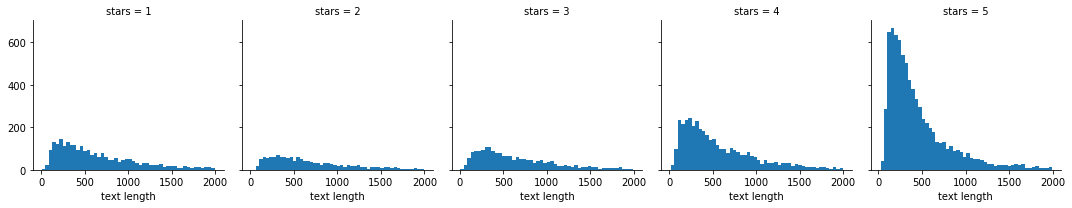

In [ ]:
g = sns.FacetGrid(data=train_df[ train_df['text length']<2000 ], col='stars')
g.map(plt.hist, 'text length', bins=50)

*   There is a high number of 4-star and 5-star reviews 
*   Text length distribution is similar across 5 ratings (skewed a lot in 4&5-star)


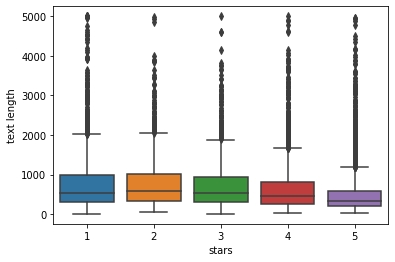

In [ ]:
sns.boxplot(x='stars', y='text length', data=train_df)



*  Text lengths are longer for fewer stars
*  Too many outliers -> text length is not usefull

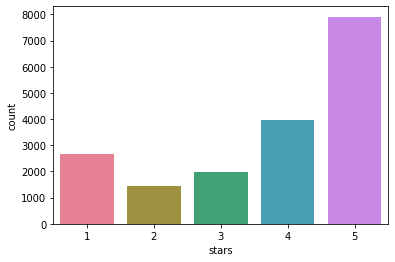

In [ ]:
sns.countplot('stars', data = train_df, palette="husl")

The data for 2,3,4 stars is too little -> hard to train model to differentiate between them

###Pre-processing helper functions

In [ ]:
def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

'''def remove_contractions(tokens):
    con = {"don't", "doesn't", "wouldn't", "won't", "isn't", "aren't", "didn't", "was't", " weren't", "shouldn't", "n't"}
    result = []
    for token in tokens:
        if token in con:
            result.append("not")
        else:
            result.append(token)
    return result'''

'''def n_gram(tokens, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
        return tokens
    else:
        results = list()
        for i in range(len(tokens)-n+1):
            # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
            results.append(" ".join(tokens[i:i+n]))
        return results'''

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import string
def filter_punctuations(tokens):
    return [token for token in tokens if token not in string.punctuation]

'''def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector'''  

def get_feats_dict(feats, min_freq=-1, max_freq=-1, max_size=-1):
    """
    :param feats: a list of features, type: list(list)
    :param min_freq: the lowest fequency that the fequency of a feature smaller than it will be filtered out
    :param max_freq: the highest fequency that the fequency of a feature larger than it will be filtered out
    :param max_size: the max size of feature dict
    return a feature dict that maps features to indices, sorted by frequencies
    # Counter document: https://docs.python.org/3.6/library/collections.html#collections.Counter
    """
    # count all features
    feat_cnt = Counter(feats) # ["text", "text", "mine"] --> {"text": 2, "mine": 1}
    if max_size > 0 and min_freq == -1 and max_freq == -1:
        valid_feats = [f for f, cnt in feat_cnt.most_common(max_size)]  #output n highest-freq (word, cnt)
    else:
        valid_feats = list()
        for f, cnt in feat_cnt.most_common():
            if (min_freq == -1 or cnt >= min_freq) and (max_freq == -1 or cnt <= max_freq):
                valid_feats.append(f)
    if max_size > 0 and len(valid_feats) > max_size:
        valid_feats = valid_feats[:max_size]        
    print("Size of features:", len(valid_feats))
    
    # build a mapping from features to indices
    feats_dict = dict(zip(valid_feats, range(len(valid_feats))))
    return feats_dict

def get_index_vector(feats, feats_dict, max_len):
    """
    :param feats: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    :param feats: a list of features, type: list
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(max_len, dtype=np.int64)
    for i, f in enumerate(feats):
        if i == max_len:
            break
        # get the feature index, return 1 (<unk>) if the feature is not existed
        f_idx = feats_dict.get(f, 1)
        vector[i] = f_idx
    return vector

###RNN classifier

In [ ]:
def build_RNN(input_length, vocab_size, embedding_size,
              hidden_size, output_size,
              num_rnn_layers, num_mlp_layers,
              rnn_type="lstm",
              bidirectional=False,
              embedding_matrix=None,
              activation="tanh",
              dropout_rate=0.0,
              batch_norm=False,
              l2_reg=0.0,
              loss="categorical_crossentropy",
              optimizer="Adam",
              learning_rate=0.001,
              metric="accuracy"):
    """
    :param input_length: the maximum length of sentences, type: int
    :param vocab_size: the vacabulary size, type: int
    :param embedding_size: the dimension of word representations, type: int
    :param hidden_size: the dimension of the hidden states, type: int
    :param output_size: the dimension of the prediction, type: int
    :param num_rnn_layers: the number of layers of the RNN, type: int
    :param num_mlp_layers: the number of layers of the MLP, type: int
    :param rnn_type: the type of RNN, type: str
    :param bidirectional: whether to use bidirectional rnn, type: bool
    :param activation: the activation type, type: str
    :param dropout_rate: the probability of dropout, type: float
    :param batch_norm: whether to enable batch normalization, type: bool
    :param l2_reg: the weight for the L2 regularizer, type: str
    :param loss: the training loss, type: str
    :param optimizer: the optimizer, type: str
    :param learning_rate: the learning rate for the optimizer, type: float
    :param metric: the metric, type: str
    return a RNN for text classification,
    # activation document: https://keras.io/activations/
    # dropout document: https://keras.io/layers/core/#dropout
    # embedding document: https://keras.io/layers/embeddings/#embedding
    # recurrent layers document: https://keras.io/layers/recurrent
    # batch normalization document: https://keras.io/layers/normalization/
    # losses document: https://keras.io/losses/
    # optimizers document: https://keras.io/optimizers/
    # metrics document: https://keras.io/metrics/
    """
    x = Input(shape=(input_length,))
    
    ################################
    ###### Word Representation #####
    ################################
    # word representation layer
    if embedding_matrix is not None:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
                        trainable=False)(x)
    else:
        emb = Embedding(input_dim=vocab_size,
                        output_dim=embedding_size,
                        input_length=input_length,
                        embeddings_initializer=keras.initializers.TruncatedNormal(mean=0.0, stddev=0.1, seed=0))(x)
    
    ################################
    ####### Recurrent Layers #######
    ################################
    # recurrent layers
    if rnn_type == "rnn":
        fn = SimpleRNN
    elif rnn_type == "lstm":
        fn = LSTM
    elif rnn_type == "gru":
        fn = GRU
    else:
        raise NotImplementedError
    h = emb
    for i in range(num_rnn_layers):
        is_last = (i == num_rnn_layers-1)
        if bidirectional:
            h = Bidirectional(fn(hidden_size,
                                 kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                                 recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                                 return_sequences=not is_last))(h)
        else:
            h = fn(hidden_size,
                   kernel_initializer=keras.initializers.glorot_uniform(seed=0),
                   recurrent_initializer=keras.initializers.Orthogonal(gain=1.0, seed=0),
                   return_sequences=not is_last)(h)
        h = Dropout(dropout_rate, seed=0)(h)
    
    ################################
    #### Fully Connected Layers ####
    ################################
    # multi-layer perceptron
    for i in range(num_mlp_layers-1):
        new_h = Dense(hidden_size,
                      kernel_initializer=keras.initializers.he_normal(seed=0),
                      bias_initializer="zeros",
                      kernel_regularizer=keras.regularizers.l2(l2_reg))(h)
        # add batch normalization layer
        if batch_norm:
            new_h = BatchNormalization()(new_h)
        # add residual connection
        if i == 0:
            h = new_h
        else:
            h = Add()([h, new_h])
        # add activation
        h = Activation(activation)(h)
    y = Dense(output_size,
              activation="softmax",
              kernel_initializer=keras.initializers.he_normal(seed=0),
              bias_initializer="zeros")(h)
    
    # set the loss, the optimizer, and the metric
    if optimizer == "SGD":
        optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
    elif optimizer == "RMSprop":
        optmizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    elif optimizer == "Adam":
        optmizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        raise NotImplementedError
    model = Model(x, y)
    model.compile(loss=loss, optimizer=optimizer, metrics=[metric])
    
    return model

###Preprocessing

In [ ]:
print(train_df.shape)
print(valid_df.shape)
print(test_df.shape)

(18000, 2)
(2000, 2)
(4000, 2)


Tokenize texts

In [ ]:
train_df['tokens'] = train_df['text'].map(tokenize).map(filter_stopwords).map(filter_punctuations).map(lower)
valid_df['tokens'] = valid_df['text'].map(tokenize).map(filter_stopwords).map(filter_punctuations).map(lower)
test_df['tokens'] = test_df['text'].map(tokenize).map(filter_stopwords).map(filter_punctuations).map(lower)

In [ ]:
print(test_df.head())

                                                text               review_id  \
0  OMG! I'm an avid spray tanner and have been al...  I77zZlSdCFAClxdjHwPcxw   
1  Sets the standard. Authentic. Outstanding. Cou...  ioFNKarf29KGjRZdH0qC8Q   
2  Came on 7/23/2014 with a group of 10 - service...  9429anmcYIcaEcMptJCNKQ   
3  I love Bobs Subs! Tasty n made to order...yum!...  PsUCdt7PKjzgBC0c7xXhJA   
4  This is my hotel of choice on the strip.  I re...  GQBlykKyShQcNeu2ivLdSA   

                                              tokens  
0  [omg, i, 'm, avid, spray, tanner, valley, with...  
1  [sets, standard, authentic, outstanding, could...  
2  [came, 7/23/2014, group, service, awful, food,...  
3  [i, love, bobs, subs, tasty, n, made, order, ....  
4  [this, hotel, choice, strip, i, really, like, ...  


In [ ]:
print(train_df['tokens'][5]) #all 'n't' i.e. 'not' are maintained

['my', 'first', 'time', 'vegas', 'however', 'first', 'time', 'buffet', 'i', 'watched', 'tube', 'read', 'reviews', 'talked', 'friends', 'came', 'conclusion', 'place', 'best', 'food', 'money', 'it', 'wasnt', 'terrible', "n't", 'good', 'most', 'food', 'cold', 'undesirable', 'the', 'wicked', 'chicken', 'wings', 'good', 'the', 'bone', 'marrow', 'nice', 'touch', 'the', 'pho', 'flavorful', 'the', 'omelet', 'delicious', 'but', 'carving', 'station', 'meat', 'cold', 'the', 'pasta', 'bland', 'the', 'sushi', 'like', 'grocery', 'store', 'the', 'deserts', "n't", 'anything', 'crazy', 'delicious', 'honestly', 'items', 'okay', 'we', 'waited', 'hours', 'eat', 'okay', 'food', 'sure', 'i', 'left', 'full', 'i', 'would', 'much', 'rather', 'checked', 'better', 'las', 'vegas', 'food', 'i', 'came', 'i', 'saw', 'ill', 'go', 'somewhere', 'else', 'next', 'time']


In [ ]:
min_freq = 3 #select words with frequencies >= 3
feats_dict = get_feats_dict(
    chain.from_iterable(list(train_df['tokens'])+list(valid_df['tokens'])))
    #,min_freq=min_freq)

Size of features: 47092


In [ ]:
len(list(train_df['tokens'])+list(valid_df['tokens']))

20000

In [ ]:
print(dict(list(feats_dict.items())[0:10]))

{'i': 0, 'the': 1, "n't": 2, "'s": 3, 'food': 4, 'good': 5, 'place': 6, 'great': 7, 'service': 8, 'we': 9}


In [ ]:
max_len = 250

# build the feats_matrix
# convert each example to a index vector, and then stack vectors as a matrix
train_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in train_df['tokens']])
valid_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in valid_df['tokens']])
test_feats_matrix = np.vstack(
    [get_index_vector(f, feats_dict, max_len) for f in test_df['tokens']])


# convert labels to label_matrix
num_classes = 5
# convert each label to a one-hot vector, and then stack vectors as a matrix
train_label_matrix = tf.keras.utils.to_categorical(train_df['stars']-1, num_classes=num_classes)
valid_label_matrix = tf.keras.utils.to_categorical(valid_df['stars']-1, num_classes=num_classes)

In [ ]:
print(test_feats_matrix.shape)

(4000, 250)


In [ ]:
print(train_feats_matrix.shape)
print(train_feats_matrix[0])
print(train_label_matrix.shape)
print(train_label_matrix[:3])

###Simple RNN

####LSTM

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 1s 39ms/step - loss: 1.2024 - accuracy: 0.6030
training loss: 1.0760687589645386 training accuracy 0.6612222194671631
test loss: 1.2023711204528809 test accuracy 0.6029999852180481


In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.5608    0.8014    0.6599       282
           2     0.3333    0.0221    0.0414       136
           3     0.3973    0.1368    0.2035       212
           4     0.4378    0.3476    0.3876       466
           5     0.6865    0.8695    0.7672       904

    accuracy                         0.6030      2000
   macro avg     0.4831    0.4355    0.4119      2000
weighted avg     0.5561    0.6030    0.5545      2000



####GRU

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 1s 33ms/step - loss: 1.3343 - accuracy: 0.5735
training loss: 0.47055062651634216 training accuracy 0.8538888692855835
test loss: 1.3342888355255127 test accuracy 0.5734999775886536


In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6689    0.6950    0.6817       282
           2     0.3109    0.2721    0.2902       136
           3     0.3519    0.2689    0.3048       212
           4     0.3817    0.3841    0.3829       466
           5     0.7085    0.7500    0.7286       904

    accuracy                         0.5735      2000
   macro avg     0.4844    0.4740    0.4777      2000
weighted avg     0.5619    0.5735    0.5667      2000



####Bi-directional LSTM

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 1s 68ms/step - loss: 1.1756 - accuracy: 0.6085
training loss: 1.0044139623641968 training accuracy 0.6842222213745117
test loss: 1.1755917072296143 test accuracy 0.6085000038146973


In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6458    0.7305    0.6855       282
           2     0.2727    0.0882    0.1333       136
           3     0.3846    0.1887    0.2532       212
           4     0.4429    0.2661    0.3324       466
           5     0.6664    0.9237    0.7742       904

    accuracy                         0.6085      2000
   macro avg     0.4825    0.4394    0.4357      2000
weighted avg     0.5548    0.6085    0.5600      2000



####Comparison

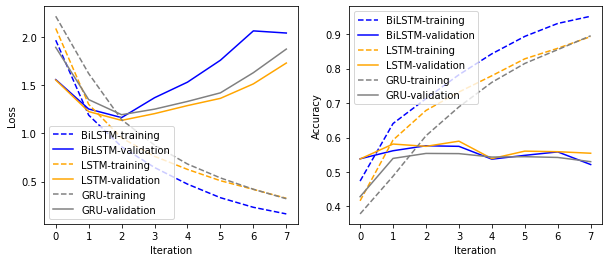

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="BiLSTM-validation", color="blue")
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["loss"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="BiLSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="BiLSTM-validation", color="blue")
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="orange", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="orange")
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="gray", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="gray")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Not so good, but all models are all stable and fast to train

###RNN with Word Embeddings

####GRU+FastText (best combination)

In [ ]:
!git clone https://github.com/facebookresearch/fastText.git
%cd fastText
!make
!cp fasttext ../
%cd ..

In [ ]:
pwd

The code below is to write save training texts into a 'reviews.txt' where each line is a sentence or a review

In [ ]:
'''with open("reviews.txt", "w") as f:
    for x in train_df['tokens']:
        sent = [w if w in feats_dict else "<unk>" for w in x]
        f.write(" ".join(sent))
        f.write("\n")
    for x in valid_df['tokens']:
        sent = [w if w in feats_dict else "<unk>" for w in x]
        f.write(" ".join(sent))
        f.write("\n")'''

In [ ]:
data_dir

'/content/drive/MyDrive/Colab Notebooks/COMP4332/Project 1/data'

In [ ]:
!./fastText/fasttext skipgram -input /content/drive/MyDrive/Colab\ Notebooks/COMP4332/Project\ 1/data/reviews.txt -output word2vec -dim 100 -minCount 3 -epoch 10

Read 2M words
Number of words:  27908
Number of labels: 0
Progress: 100.0% words/sec/thread:   10484 lr:  0.000000 avg.loss:  2.156535 ETA:   0h 0m 0s


Build embedding matrix

In [ ]:
embedding_matrix = np.zeros((len(feats_dict), 100), dtype=np.float32)
with open("word2vec.vec", "r") as f:
    n_words, n_dim = f.readline().split()
    n_words, n_dim = int(n_words), int(n_dim) 
    print("number of words:", n_words, "word dimension:", n_dim)
    while True:
        line = f.readline()
        if not line:
            break
        word, vec = line.split(" ", 1)
        word_idx = feats_dict.get(word, -1)
        if word_idx != -1:
            embedding_matrix[word_idx] = np.array(vec.split(), dtype=np.float32)

number of words: 27908 word dimension: 100


In [ ]:
print(embedding_matrix[:5])

In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score

class Metrics(Callback):
  
  def on_train_begin(self, logs={}):
    self.f1s = []
 
  def on_epoch_end(self, epoch, logs={}):
    val_predict = np.argmax(self.model.predict(valid_feats_matrix), axis = 1) + 1
    val_targ = valid_df["stars"]
    f1 = f1_score(val_targ, val_predict, average='macro')
    self.f1s.append(f1)
    print("\nmacro-f1: ",f1)
    return
 
metrics = Metrics()
#pred = np.argmax(self.model.predict(valid_feats_matrix), axis = 1) + 1

def f1(y_true, y_pred):
    val_predict = np.argmax(y_true, axis = 1) + 1
    val_targ = valid_df["stars"]
    f1 = f1_score(val_targ, val_predict, average='macro')
    return f1

Save all models

In [ ]:
models_path = "/content/drive/MyDrive/epoch1"
checkpoint_path = os.path.join(models_path, "cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    monitor="val_accuracy",
    verbose=0)#,
    #save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=40, batch_size=100, verbose=1,
                    callbacks=[checkpointer, metrics])#, earlystopping]) #train for 40 epochs
'''
model = keras.models.load_model(os.path.join("/content/drive/MyDrive", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])'''

Loss and Accuracy

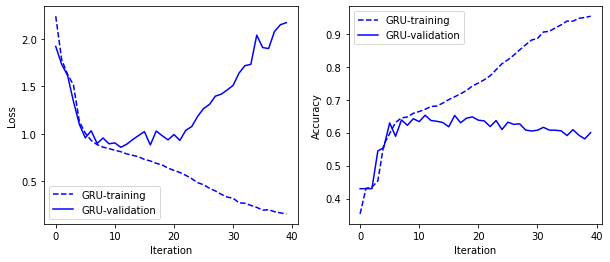

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(gru_history.history["loss"], label="GRU-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="GRU-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(gru_history.history["accuracy"], label="GRU-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="GRU-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Macro-f1 score

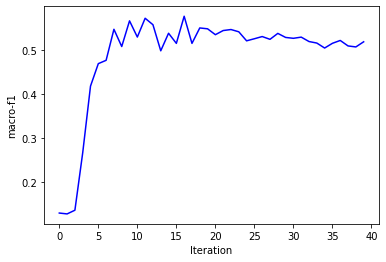

In [ ]:
plt.plot(metrics.f1s, color="blue")
plt.xlabel("Iteration")
plt.ylabel("macro-f1")
plt.show()

Load best model

In [ ]:
os.listdir(checkpoint_dir)[:3]

In [ ]:
print(np.argmax(metrics.f1s)+1)
metrics.f1s[np.argmax(metrics.f1s)]

17


0.5760763558042914

In [ ]:
models_path

#####Load best model

In [ ]:
model = keras.models.load_model(os.path.join(models_path, "cp-0017.ckpt"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 6s 279ms/step - loss: 0.8590 - accuracy: 0.6550
training loss: 0.6912056803703308 training accuracy 0.7155555486679077
test loss: 0.8590195775032043 test accuracy 0.6549999713897705


In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.8051    0.6738    0.7336       282
           2     0.3204    0.4265    0.3659       136
           3     0.4312    0.5613    0.4877       212
           4     0.5433    0.4442    0.4888       466
           5     0.7948    0.8142    0.8044       904

    accuracy                         0.6550      2000
   macro avg     0.5790    0.5840    0.5761      2000
weighted avg     0.6669    0.6550    0.6575      2000



evaluate.py

In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(len(pred))
# save model validation predictions
pred_df = pd.DataFrame({'stars': pred, 'review_id': valid_df['review_id']})
pred_df.to_csv('valid_pred.csv', index=False)

2000


In [ ]:
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

ans = pd.read_csv("valid.csv", usecols=["review_id", "stars"])
pred = pd.read_csv("valid_pred.csv", usecols=["review_id", "stars"])
df = pd.merge(ans, pred, how="left", on=["review_id"])
df.fillna(0, inplace=True)
acc = accuracy_score(df["stars_x"], df["stars_y"])
p, r, f1, _ = precision_recall_fscore_support(df["stars_x"], df["stars_y"], average="macro")
print("accuracy:", acc, "\tprecision:", p, "\trecall:", r, "\tf1:", f1)


accuracy: 0.655 	precision: 0.5789619312607682 	recall: 0.5839831017639183 	f1: 0.5760763558042914


#####Final prediction

In [ ]:
pred = np.argmax(model.predict(test_feats_matrix), axis = 1) + 1
print(len(pred))
# save your model predictions
pred_df = pd.DataFrame({'stars': pred, 'review_id': test_df['review_id']})
pred_df.to_csv('pred.csv', index=False)

4000


This model achieved the highest score for this approach with the macro-f1 is 0.576

####LSTM+Word2Vec

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  lstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=50, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 5ms/step - loss: 0.8547 - accuracy: 0.6475
training loss: 0.7776676416397095 training accuracy 0.6791666746139526
test loss: 0.854686439037323 test accuracy 0.6474999785423279


In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6716    0.8121    0.7352       282
           2     0.4000    0.2647    0.3186       136
           3     0.4753    0.3632    0.4118       212
           4     0.4816    0.4785    0.4801       466
           5     0.7733    0.8075    0.7900       904

    accuracy                         0.6475      2000
   macro avg     0.5604    0.5452    0.5471      2000
weighted avg     0.6340    0.6475    0.6379      2000



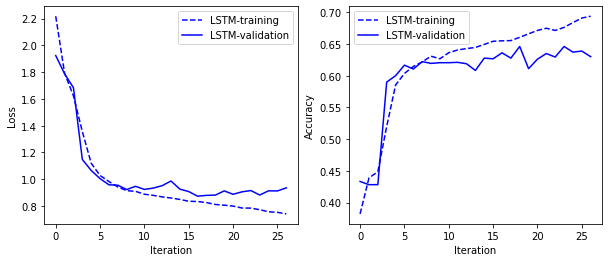

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(lstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(lstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(lstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

####BiLSTM+Word2Vec


In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="lstm", num_rnn_layers=1, bidirectional=True, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="tanh",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  bilstm_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=100, batch_size=100, verbose=0,
                    callbacks=[checkpointer, earlystopping])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

20/20 [==============================] - 0s 7ms/step - loss: 0.9093 - accuracy: 0.6425
training loss: 0.7103791832923889 training accuracy 0.7158889174461365
test loss: 0.9092768430709839 test accuracy 0.6424999833106995


In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6500    0.8759    0.7462       282
           2     0.3924    0.2279    0.2884       136
           3     0.3684    0.2972    0.3290       212
           4     0.4884    0.4957    0.4920       466
           5     0.7949    0.7887    0.7918       904

    accuracy                         0.6425      2000
   macro avg     0.5388    0.5371    0.5295      2000
weighted avg     0.6305    0.6425    0.6322      2000



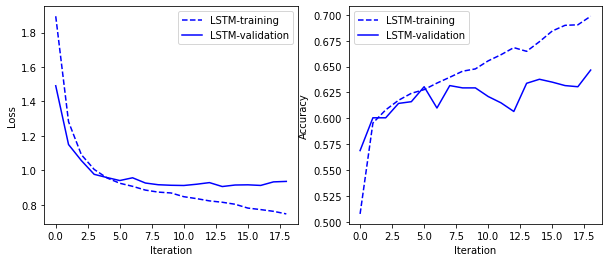

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(bilstm_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(bilstm_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(bilstm_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Diverged already -> maybe not good

####GRU+GloVe


Load GloVe

In [ ]:
pwd

'/content'

In [ ]:
path_to_glove_file = os.path.join('/content/drive/MyDrive','glove.6B.100d.txt')

embedding_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embedding_index[word] = coefs

print("Found %s word vectors." % len(embedding_index))

Found 400000 word vectors.


Build Embedding matrix

In [ ]:
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((len(feats_dict), embedding_dim))
for word, i in feats_dict.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 31058 words (13697 misses)


In [ ]:
embedding_matrix[:5]

In [ ]:
os.makedirs("models", exist_ok=True)
model = build_RNN(input_length=max_len, vocab_size=len(feats_dict),
                  embedding_size=100, hidden_size=100, output_size=num_classes,
                  rnn_type="gru", num_rnn_layers=1, num_mlp_layers=2,
                  embedding_matrix=embedding_matrix,
                  activation="softmax",
                  optimizer="RMSprop",
                  batch_norm=True,
                  l2_reg=0.005, dropout_rate=0.5)
checkpointer = keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("models", "weights.hdf5"),
    monitor="val_accuracy",
    verbose=0,
    save_best_only=True)
earlystopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=0)

np.random.seed(0)
tf.random.set_seed(0)

with tf.device('/gpu:0'):
  gru_history = model.fit(train_feats_matrix, train_label_matrix,
                    validation_split=0.1,
                    epochs=40, batch_size=100, verbose=0,
                    callbacks=[checkpointer, metrics])#earlystopping, metrics])

model = keras.models.load_model(os.path.join("models", "weights.hdf5"))

train_score = model.evaluate(train_feats_matrix, train_label_matrix,
                             batch_size=100)
test_score = model.evaluate(valid_feats_matrix, valid_label_matrix,
                            batch_size=100)
print("training loss:", train_score[0], "training accuracy", train_score[1])
print("test loss:", test_score[0], "test accuracy", test_score[1])

In [ ]:
pred = np.argmax(model.predict(valid_feats_matrix), axis = 1) + 1
print(classification_report(valid_df["stars"], pred, digits=4))

              precision    recall  f1-score   support

           1     0.6687    0.7589    0.7110       282
           2     0.3125    0.2574    0.2823       136
           3     0.5294    0.3396    0.4138       212
           4     0.4850    0.4163    0.4480       466
           5     0.7413    0.8462    0.7903       904

    accuracy                         0.6400      2000
   macro avg     0.5474    0.5237    0.5291      2000
weighted avg     0.6197    0.6400    0.6249      2000



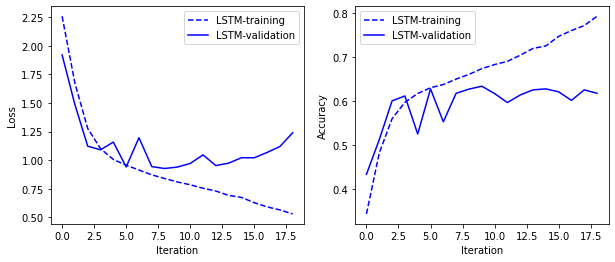

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(gru_history.history["loss"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_loss"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(gru_history.history["accuracy"], label="LSTM-training", color="blue", linestyle="dashed")
plt.plot(gru_history.history["val_accuracy"], label="LSTM-validation", color="blue")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

No signal for GloVe